In [1]:
# =============================================================================
# Import Libraries and functions
from Data_preparation import data_processing_with_BH_scaled
import numpy as np
import torch
import gpytorch
import os
import matplotlib.pyplot as plt
from botorch.models import MultiTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood 
from gpytorch.kernels.keops import MaternKernel
from gpytorch.kernels import ScaleKernel, ProductKernel
import tqdm
import cloudpickle
from glob import glob
from scipy.special import eval_sh_legendre, eval_sh_jacobi
from scipy.stats import entropy
from torch.optim import SGD, Adam
from botorch.models.transforms.outcome import Standardize
from gpytorch.likelihoods.gaussian_likelihood import (
    FixedNoiseGaussianLikelihood)


cwd = os.getcwd()
plots_folder = cwd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
dtype = torch.float32
# =============================================================================

plots_folder = glob("..\\Plots\\")[0]
pickles_folder = glob("..\\Pickles\\")[0]

def Pickle_file(folder, filename, data):
    with open(folder + filename + '.pkl', mode='wb') as file:
        cloudpickle.dump(data, file)
        
def Unpickle_file(folder,filename):
    with open(folder+ filename + '.pkl', mode='rb') as file:
        data = cloudpickle.load(file)
    return data

In [2]:
dis_depth = 185
num_vertical_des_points = 325   
num_cpts_w_bhs = 26   # 5 bhs + (num-5) cpts
bh_ids = [0, 1, 11, 19, 23] # for 20
num_bhs = 5

data_qc, xt, yt, zt, grid, \
    z_mat, mapping, Dxy, Dz, depth_0 = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        "qc")
    
data_fs, _, _, _, \
    _, _, _, _, _, _ = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        "fs")    
    

ids = [i for i in range(data_qc.shape[1])]
cpt_ids = [i for i in ids if i not in bh_ids]

data_qc[:, [i for i in ids if i not in bh_ids]] = np.log(data_qc[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])   

data_fs[:, [i for i in ids if i not in bh_ids]] = np.log(data_fs[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])   

C:\Users\ozinas\AppData\Local\Temp\ipykernel_2272\3542038242.py:29: RuntimeWarning: invalid value encountered in log
  data_fs[:, [i for i in ids if i not in bh_ids]] = np.log(data_fs[:,


In [3]:
data_bhs = data_qc[:, bh_ids]
y_nonnan_bhs = data_bhs.T.ravel()
y_nonnan_bhs = y_nonnan_bhs[~np.isnan(y_nonnan_bhs)]
len_nonnan_bhs = len(y_nonnan_bhs)
train_x_bhs = torch.zeros((len_nonnan_bhs, 3), dtype = dtype)
rowind = 0;
for i, dat in enumerate(data_bhs.T):
    idni = len(dat[~np.isnan(dat)])
    idni = len(dat[~np.isnan(dat)])
    train_x_bhs[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_bhs[rowind:rowind+idni, 1] = grid[1][bh_ids[i]]
    train_x_bhs[rowind:rowind+idni, 2] = grid[2][bh_ids[i]]
    rowind +=idni

data_qc[data_qc == -np.inf] = np.nan
data_fs[data_fs == -np.inf] = np.nan
data_qc = data_qc[:, cpt_ids]
data_fs = data_fs[:, cpt_ids]


idnan = np.isnan(data_fs).T.ravel()
id_nonnan_qc = ~np.isnan(data_qc.T.ravel())
id_nonnan_fs = ~np.isnan(data_fs.T.ravel())

y_nonnan_qc = data_qc.T.ravel()
y_nonnan_qc = y_nonnan_qc[id_nonnan_fs]

y_nonnan_fs = data_fs.T.ravel()
y_nonnan_fs = y_nonnan_fs[id_nonnan_fs]

len_nonnan_cpts = len(y_nonnan_qc)
# create the train_x for cpts
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()

train_x_cpts = torch.zeros((len_nonnan_cpts, 3), dtype = dtype)
rowind = 0; 
for i, dat in enumerate(data_fs.T):
    idni = len(dat[~np.isnan(dat)])
    train_x_cpts[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_cpts[rowind:rowind+idni, 1] = grid[1][i]
    train_x_cpts[rowind:rowind+idni, 2] = grid[2][i]
    rowind +=idni

In [4]:
# Standardize Ic data

mu_qc = np.mean(np.exp(y_nonnan_qc))
std_qc = np.std(np.exp(y_nonnan_qc))
mu_fs = np.mean(np.exp(y_nonnan_fs))
std_fs = np.std(np.exp(y_nonnan_fs))

def pars_log(mu_x,std_x):
    std_x_log = np.sqrt(np.log(std_x**2/mu_x**2 +1))
    mu_x_log = np.log(mu_x)-(std_x_log**2)/2    
    return mu_x_log,std_x_log

mu_qc_log, std_qc_log = pars_log(mu_qc, std_qc) 
mu_fs_log, std_fs_log = pars_log(mu_fs, std_fs) 

# data_cpts_stdzd = (data_cpts - mu_cpt_log) / std_cpt_log
data_qc_stdzd = (y_nonnan_qc.reshape(-1, 1) - mu_qc_log) / std_qc_log
data_fs_stdzd = (y_nonnan_fs.reshape(-1, 1) - mu_fs_log) / std_fs_log

In [5]:
# Prepare borehole data

y = data_bhs.copy().T.ravel()
y = y[~np.isnan(y)]
y_vec = y.astype(int)
y_discrete = torch.tensor(y_vec).long()
classes = np.unique(y_vec)
num_classes = len(classes)
Y = np.zeros((len(y_vec), len(classes)))
for i, e in enumerate(y_vec):
    # print(i, e)
    Y[i, np.where(classes == e)[0]] = 1
    
# label transformation
a_eps = 0.002    
# a_eps = 0.03

s2_tilde = np.log(1.0 / (Y + a_eps) + 1)
Y_tilde = np.log(Y + a_eps) - 0.5 * s2_tilde

In [6]:
train_y = torch.cat([torch.tensor(Y_tilde).mT.ravel(), 
                       torch.tensor(data_qc_stdzd).ravel(), 
                       torch.tensor(data_fs_stdzd).ravel()], -1)

mean_ytilde = np.mean(Y_tilde)
std_Y_tilde = np.std(Y_tilde)

train_Yvar_bhs = torch.tensor(s2_tilde).mT.ravel().unsqueeze(-1)
train_Yvar_qc = torch.ones_like(torch.tensor(data_qc_stdzd)) * torch.tensor(1e-5) # 0.01 or setting, 0.0001
train_Yvar_fs = torch.ones_like(torch.tensor(data_fs_stdzd)) * torch.tensor(1e-5) # 0.01 or setting, 0.0001

# Should I use the exp of the noise? Lokk again documentation
train_Yvar = torch.cat([train_Yvar_bhs, train_Yvar_qc, train_Yvar_fs])

In [7]:
# create the train_x full with index 
num_tasks = num_classes + 2
i_ind = torch.zeros(train_x_bhs.shape[0], num_tasks)
for i in range(num_tasks):
    i_ind[:, i] = torch.ones(train_x_bhs.shape[0]) * i
    
i_ind_qc = torch.ones(train_x_cpts.shape[0])*int(num_classes)
i_ind_fs = torch.ones(train_x_cpts.shape[0])*int(num_classes + 1)

# ------------------------------------------------------------------------------
# Needs to be modified according to the number of classes present in the training
# data! Depends on the vertical num points 

train_Xf = torch.cat([
     torch.cat([train_x_bhs, i_ind[:, 0].view(-1,1)], -1), 
     torch.cat([train_x_bhs, i_ind[:, 1].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 2].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 3].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 4].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 5].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 6].view(-1,1)], -1),
     torch.cat([train_x_cpts, i_ind_qc.view(-1,1)], -1),
     torch.cat([train_x_cpts, i_ind_fs.view(-1,1)], -1)
 ], 0)



train_Xbhs = torch.cat([torch.cat([train_x_bhs, i_ind[:, i].view(-1,1)], -1) for i in range(num_classes)])
train_x_bhsn = train_Xbhs[:,:-1]

train_Xf = train_Xf.type(dtype=dtype)
train_i = train_Xf[:, -1].long()
train_X = train_Xf[:,:-1].type(dtype).detach()

train_Y = train_y.unsqueeze(-1)
train_yvar = train_Yvar

In [8]:
# We'll learn 1200 inducing points for each process
# Here just to initialize the model (not used afterwards)
num = 1500

inducing_points1 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num]]
inducing_points2 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num]]
inducing_points3 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num]]
inducing_points4 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num]]
inducing_points5 = train_x_cpts[torch.randperm(train_x_cpts.size(0))[:num]]
inducing_points6 = train_x_cpts[torch.randperm(train_x_cpts.size(0))[:num]]

inducing_points = torch.cat([inducing_points1.unsqueeze(0), inducing_points2.unsqueeze(0), 
                            inducing_points3.unsqueeze(0), inducing_points4.unsqueeze(0), 
                            inducing_points5.unsqueeze(0),inducing_points6.unsqueeze(0)], dim = 0).to(dtype).to(device)


#inducing_points = Unpickle_file(pickles_folder, 'inducing_points_6lat_LMCvar_qcfsbh_200v_50it_256_aeps001_const_lr015').cpu()


In [9]:
from gpytorch.means.mean import Mean
from torch import Tensor
# -----------------------------------------------------------------------------------------------------------
from gpytorch.means.mean import Mean
from torch import Tensor
# Legendre mean

#drop_ids = [ 5,  8, 10, 15, 16, 17, 19]    # legendre (20)
drop_ids = [0]                              # jacobi 8 (0.8,0.1)

def get_design_mat_1d(loc, deg):
    H = torch.tensor(np.array([eval_sh_jacobi(n, 0.8, 0.1, loc) for n in range(deg)]).T, dtype = dtype)
    return H
   
class jacobi_poly(gpytorch.means.Mean):
    # currently works for constant trent in horizntal!!
    def __init__(self,  batch_shape = torch.Size(), mx = 1, my = 1, mz = 8):
        super().__init__()
        #self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
        w =  torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype)[:mz].unsqueeze(0)


        self.mx = mx
        self.my = my
        self.mz = mz
        self.batch_shape = batch_shape

        self.register_parameter(name="weights", 
                                parameter=torch.nn.Parameter(
                                    torch.randn(*batch_shape,  1, self.mz,device=device,dtype=dtype)[..., :, :8- len(drop_ids)]))


    def Dmat( self, x):

        with torch.no_grad():

            if len(x.shape)<=2:
                Phi11 = get_design_mat_1d(x[:, 1].reshape(-1,1).detach().cpu().numpy(), self.mx ).squeeze(0)
                Phi22 = get_design_mat_1d(x[:, 2].reshape(-1,1).detach().cpu().numpy(), self.my ).squeeze(0)
     
                Phi_h = torch.einsum('...ik,...il->...ikl', Phi11, Phi22).squeeze(-1).to(device)
            
                Phi_v = get_design_mat_1d(x[:, 0].reshape(-1,1).detach().cpu().numpy(), self.mz).squeeze(0).to(device)


                #=====================================================================
                Phi_v = Phi_v[..., :, [j for j in torch.arange(self.mz) if j not in drop_ids]]
                #=====================================================================
                res = torch.einsum( '...i,...jk,...ji ->  ...j', self.weights, Phi_h, Phi_v ).squeeze(-2)

                
                return res
    
            else:
                #res2 = torch.empty(num_latents, x.shape[1])
                res2 =0
                for i in range(num_latents):
                    Phi11 = get_design_mat_1d(x[i, :, 1].reshape(-1,1).detach().cpu().numpy(), 1 ).squeeze(0)
                    Phi22 = get_design_mat_1d(x[i, :, 2].reshape(-1,1).detach().cpu().numpy(), 1 ).squeeze(0)
     
                    #Phi_h = torch.einsum('...ik,il->...ikl', Phi11, Phi22).squeeze(-1).to(device)
                    Phi_h = torch.einsum('...ik,...il->...ikl', Phi11, Phi22).squeeze(-1).to(device)
                    Phi_v = get_design_mat_1d(x[i, :, 0].reshape(-1,1).detach().cpu().numpy(), self.mz).squeeze(0).to(device)

                    #=====================================================================
                    Phi_v = Phi_v[..., :, [j for j in torch.arange(self.mz) if j not in drop_ids]]
                    #=====================================================================

                    res2=torch.einsum( '...i,...jk,...ji ->  ...j', self.weights, Phi_h, Phi_v ).squeeze(-2)
                #.reshape(x.shape[:-1])[0]
                #return res2
                    return res2
    
    def forward( self, x):
        # if self.training:
        res = self.Dmat(x)

        return res

In [10]:
# Build the model
num_latents = 6
#num_latents = 1
#inducing_points = train_X.to(device)
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, likelihood):

        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        #super(MultitaskGPModel, self).__init__(noise)
        super(MultitaskGPModel, self).__init__(variational_strategy)
        self.likelihood = likelihood
        #self.mean_module = jacobi_poly(batch_shape=torch.Size([num_latents]), mx=1, my=1, mz=8)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = ScaleKernel(ProductKernel(MaternKernel(nu=0.5,active_dims=torch.tensor([0]),
                                                                    batch_shape=torch.Size([num_latents])),               
                                    MaternKernel(nu=0.5, active_dims=torch.tensor([1, 2]),
                                                  batch_shape=torch.Size([num_latents]))),
                                        batch_shape=torch.Size([num_latents]))

    def forward(self, x):

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
# Use the botorch function to find some appropriate inducing points for initialization

from torch import Tensor
from botorch.models.utils.inducing_point_allocators import (GreedyVarianceReduction, InducingPointAllocator)

inducing_point_allocator = GreedyVarianceReduction()
def init_inducing_points(
        inputs: Tensor,
    ) -> Tensor:
        r"""
        Reinitialize the inducing point locations in-place with the current kernel
        applied to `inputs` through the model's inducing point allocation strategy.
        The variational distribution and variational strategy caches are reset.

        Args:
            inputs: (\*batch_shape, n, d)-dim input data tensor.

        Returns:
            (\*batch_shape, m, d)-dim tensor of selected inducing point locations.
        """
        var_strat = model.variational_strategy
        var_strat = var_strat.base_variational_strategy
        with torch.no_grad():
            num_inducing = var_strat.inducing_points.size(-2)
            inducing_points = inducing_point_allocator.allocate_inducing_points(
                inputs=inputs,
                covar_module=model.covar_module,
                num_inducing=num_inducing,
                input_batch_shape=torch.Size([num_latents]),
            )
            var_strat.inducing_points.copy_(inducing_points)
            var_strat.variational_params_initialized.fill_(0)

        return inducing_points

In [12]:

# #state_dict = torch.load('VLMC_strat_qc-fs-uscs-constant.pth')



# likelihood  = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1))
# model = MultitaskGPModel(inducing_points = inducing_points, likelihood = likelihood)
# model.load_state_dict(state_dict)
# train_X, train_y, train_i = train_X.to(device).contiguous(), train_y.to(device).contiguous(), train_i.to(device).contiguous()
# train_yvar = train_yvar.to(device).contiguous()
# model = model.to(device)
# likelihood = likelihood.to(device)

In [13]:
# call the model and initialize hyperparameters
likelihood  = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1))

model = MultitaskGPModel(inducing_points = inducing_points, likelihood = likelihood)
ini_inducing_points = init_inducing_points(train_X)
model = MultitaskGPModel(inducing_points = ini_inducing_points, likelihood = likelihood)

model.covar_module.base_kernel.kernels[0].lengthscale = torch.tensor([0.0271], dtype = dtype, device = device)  #ini
model.covar_module.base_kernel.kernels[1].lengthscale = torch.tensor([0.15], dtype = dtype, device = device)

train_X, train_y, train_i = train_X.to(device).contiguous(), train_y.to(device).contiguous(), train_i.to(device).contiguous()
train_yvar = train_yvar.to(device).contiguous()
model = model.to(device)
model.likelihood = model.likelihood.to(device)

In [14]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_X, train_i, train_y, train_yvar)
train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)


In [17]:
# Train the model in batches
hyperparameter_optimizer  = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.001)

model.train()
model.likelihood.train()

#-------------------------------------------------------------------------------------------------------------------
mll = lambda noise: gpytorch.mlls.PredictiveLogLikelihood(FixedNoiseGaussianLikelihood(noise=noise.squeeze(-1)),
                                                             model, num_data=train_y.numel())

# mll = lambda noise: gpytorch.mlls.VariationalELBO(FixedNoiseGaussianLikelihood(noise=noise.squeeze(-1)),
#                                                            model, num_data=train_y.numel())

#-------------------------------------------------------------------------------------------------------------------

num_epochs = 200
#epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
loss_curve = []
for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    loss_sum = 0
    for x_batch, i_batch, y_batch, y_var_batch in minibatch_iter:

        hyperparameter_optimizer.zero_grad()
        output = model(x_batch, task_indices = i_batch)

        loss = -mll(y_var_batch)(output, y_batch)
        loss_sum += loss
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        hyperparameter_optimizer.step()
    #scheduler.step()   #if a scheduler is used
    loss_mean = loss_sum / 4 
    loss_curve.append(loss_mean.cpu().detach().numpy())
    #epochs_iter.set_postfix(loss_mean=loss_mean.item(), lr = scheduler.get_last_lr())
    epochs_iter.set_postfix(loss_mean=loss_mean.item())

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
#torch.save(model.state_dict(), 'VLMC_strat_qc-fs-uscs-constant.pth')


In [19]:
arr = model.variational_strategy.lmc_coefficients.cpu().detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
print(arr)

[[3.3342 -0.7135 1.2774 1.2769 0.3340 0.2740 2.8353 0.0061 -0.4718]
 [-0.4111 0.3096 1.7548 2.1900 -1.9692 1.2981 -0.8968 -1.3183 -0.3702]
 [-0.3675 4.0943 0.1475 -0.2762 1.5962 -1.9673 0.4670 -0.1780 -0.2904]
 [-0.8911 0.3619 2.1359 2.2320 1.5782 1.0358 1.9215 0.1868 0.7509]
 [-1.2086 -0.8017 -0.1825 -0.2623 -2.1088 -3.0659 2.7135 -0.0972 0.1165]
 [0.3908 -2.0381 0.2150 0.4486 3.3697 -2.3889 -1.7613 -0.4509 -0.3847]]


In [20]:
# Predictions (at verification boreholes)
Dz = np.max(z_mat) 

# xcoords (BH_9,BH_1,H_5,BH_3) = [55.7300 104.2000 149.7200 192.4700] m
# ycoords (BH_9,BH_1,H_5,BH_3) = [16.1100 71.5800 21.6400 70.8200] m

x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])       # the scaled (divided by Dx) locations of the verification boreholes 
y_p_m = np.array([0.07981174, 0.35461977, 0.10720832, 0.35085459])       # the scaled (divided by Dx) locations of the verification boreholes 


nv_test = 2745 - int(1.86/0.01) + 1
nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = np.linspace(0.00, np.max(grid[0].numpy()), nv_test)
z_t = np.linspace(0.00, 1, nv_test)

x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h

grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]

test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(train_X)

In [21]:
test_dataset = TensorDataset(test_x, test_x)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [22]:
# =============================================================================
# Prediction of USCS marginals (need to sample)
# =============================================================================
# Boreholes are sorted with respect to x!!
bh_names = ["bh9", "bh1", "bh5", "bh3"]

# x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])
# y_p_m = np.array([0.16800501, 0.74648034, 0.22567525, 0.73855459])


means = []; lower = []; upper = [] ; q10 = []; q90 = []
probs_batched = []
#pred_samples_batched = []
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False,  solves=False),\
    gpytorch.settings.use_toeplitz(False):
        for x_batch_t,_ in test_loader:
            num = len(torch.unique(x_batch_t[:,0]))
            #predictions = likelihood(model(x_batch_t, output_indices=[len(classes)]))
            predictions = likelihood(model(x_batch_t))
            means.append(predictions.mean.cpu())
            l, u = predictions.confidence_region()
            lower.append(l)
            upper.append(u)

            std = predictions.variance.sqrt()
  
            quantile_qc_10 = predictions.mean - 1.96*std
            quantile_qc_90 = predictions.mean + 1.96*std

            q10.append(quantile_qc_10)
            q90.append(quantile_qc_90)

            samples_uscs = predictions.sample(torch.Size((400,)))
            pred_samples_uscs = samples_uscs.exp()[:,..., :len(classes)]  
            probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))

C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


In [23]:
mean = torch.concat([means[i] for i in range(len(means))], dim=0)
lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)


In [24]:
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()
post_median_qc = (mean[..., -2].cpu()  * std_qc_log + mu_qc_log)   
post_median_fs = (mean[..., -1].cpu()  * std_fs_log + mu_fs_log)   

lower_qc = lower[..., -2].cpu() * std_qc_log + mu_qc_log        
upper_qc = upper[..., -2].cpu() * std_qc_log + mu_qc_log  

lower_fs = lower[..., -1].cpu() * std_fs_log + mu_fs_log        
upper_fs = upper[..., -1].cpu() * std_fs_log + mu_fs_log  

In [25]:
def compute_Isbt(qc, fs):
    Rf = fs / qc * 100
    return np.sqrt((3.47 - np.log10(qc/0.1))**2 +
                       (1.22 + np.log10(Rf))**2)
def compute_Rf(qc, fs):
    return fs / qc * 100

In [26]:
inv_map = {v: k for k, v in mapping.items()}
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
depth_max = np.max(depth_points)
depth = z_t * (Dz - depth_0) + depth_0       

N = np.array([i for i in range(num_classes)])
R = [inv_map[classes[i]] for i in N] 

def most_probable_uscs(prob, mapping, inv_map):
    num_classes = prob.shape[-1]
    max_probs = np.zeros(prob.shape[0])
    probs_np = prob.cpu().detach()
    most_prob_profile = np.zeros(prob.shape[0])
    H = np.zeros(prob.shape[0])
    for i in range(len(prob)):
        max_prob_id = np.argmax(probs_np[i].numpy())
        most_prob_profile[i] = (max_prob_id + mapping[R[0]])
        max_probs[i] = probs_np[i][max_prob_id]
        H[i] = entropy(probs_np[i].numpy(), base = 2) / entropy(np.ones(num_classes) / num_classes , base = 2)
        
    return most_prob_profile, max_probs, H


most_prob_profile = np.empty((nh_test, nv_test))
max_probs = np.empty((nh_test, nv_test))
H = np.empty((nh_test, nv_test))

for i, probs in enumerate(probabilities):
    most_prob_profile[i], max_probs[i], H[i] = most_probable_uscs(probs, mapping, inv_map)

In [27]:
# Load and transform the true uscs data at verification boreholes

from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score
import pandas as pd

# classifier
def load_data_classes(file):
    return np.array(pd.read_excel(glob("..\\Input\\"+file)[0]),dtype=str)

classes_bh_all = load_data_classes("bhs_all.xlsx")
# classes_bh_all = load_data_classes("bhs_all.xlsx")

label_encoder = LabelEncoder()
# Fit the LabelEncoder to the USCS class labels and transform them into categorical variables
encoded_classes = label_encoder.fit_transform(classes_bh_all.ravel(order="f")).reshape(classes_bh_all.shape, order = "f")
or_classes = classes_bh_all[:, [0, 2, 4, 8]]
or_classes = classes_bh_all[:, [8, 0, 4, 2]]


train_classes_bh = encoded_classes[:, [1, 3, 5, 6, 7]]
test_classes_bh = or_classes

df_test = pd.DataFrame(test_classes_bh,
                       columns = ["BH_9", "BH_1", "BH_5", "BH_3"])
z_test = z_mat[:,0]
df_test["z"] = z_test

C:\Users\ozinas\AppData\Local\Temp\ipykernel_2272\3030777064.py:194: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_2272\3030777064.py:194: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_2272\3030777064.py:194: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_2272\3030777064.py:194: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


tensor([[[0.0871]],

        [[0.1165]],

        [[0.0860]],

        [[0.0994]],

        [[0.0622]],

        [[0.0638]]])
tensor([[[0.3359]],

        [[0.5510]],

        [[0.5596]],

        [[0.2611]],

        [[0.4058]],

        [[0.1926]]])


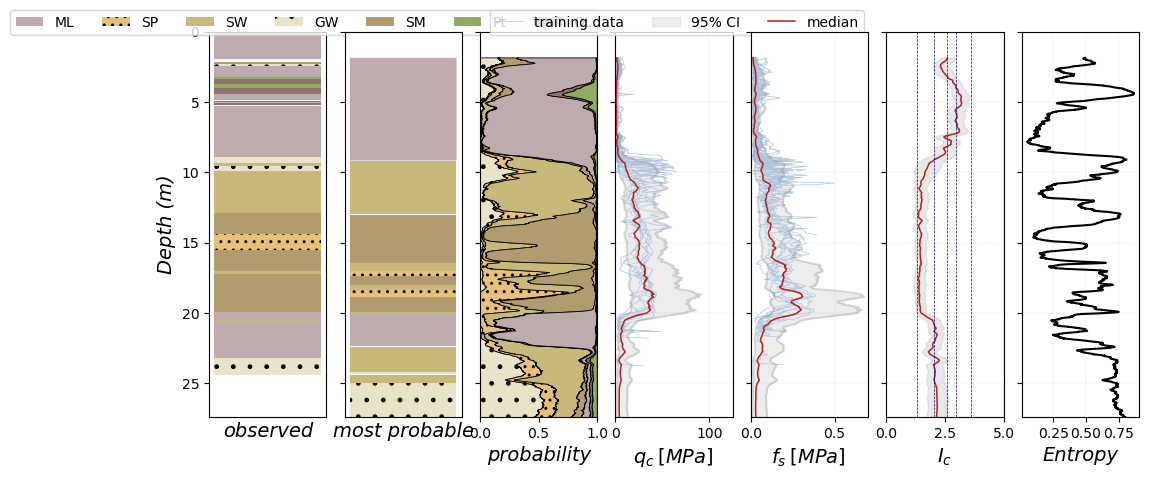

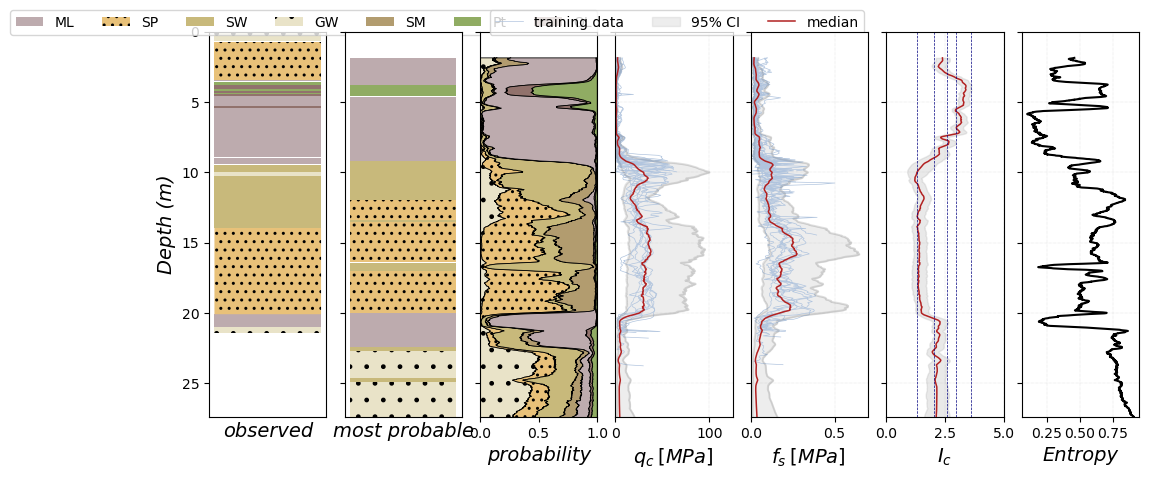

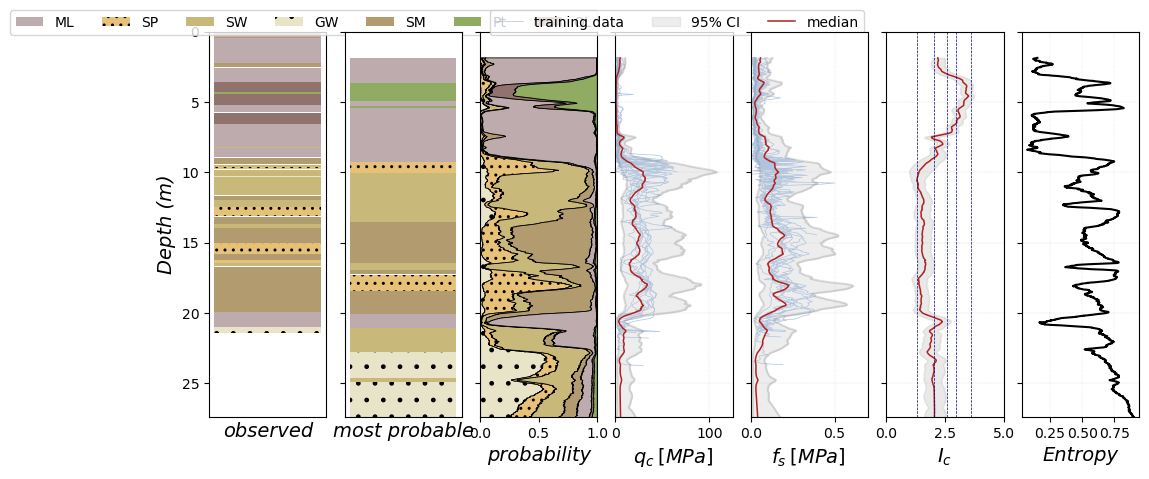

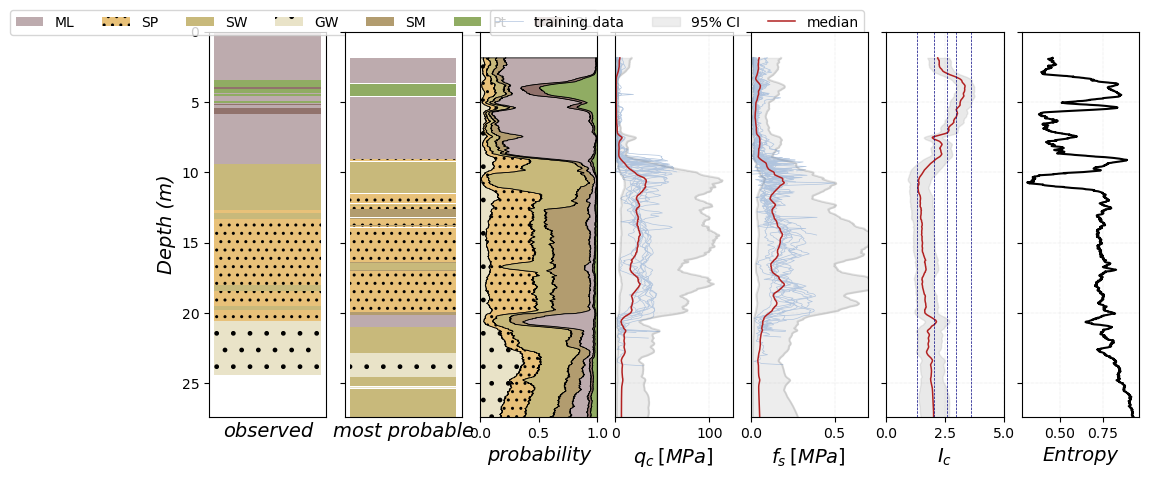

In [28]:
# =============================================================================
# Plots
# =============================================================================
hatches=['.','..','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))
    

# lithological plots
# SEE: https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

lithology_colors = [(0.9137254901960784, 0.8895686274509804, 0.7843921568627451),      
          (0.9090, 0.75640, 0.4750),              
          (0.7843137254901961, 0.7239215686274509, 0.4835294117647059),
          (0.6980392156862745, 0.6134901960784314, 0.4369411764705882),
          (0.7411764705882353, 0.6687058823529413, 0.6831764705882354),
          (0.5686274509803921, 0.4478431372549019, 0.4219607843137255), 
          (0.5660, 0.6740, 0.3880)]


lithology_numbers = {'ML': {'name':'ML', 'lith_num':1, 'hatch': hatches[Rn.index("ML")], 'color':lithology_colors[Rn.index("ML")]},
                 'SP': {'name':'SP', 'lith_num':2, 'hatch': hatches[Rn.index("SP")], 'color':lithology_colors[Rn.index("SP")]},
                 'SW': {'name':'SW', 'lith_num':3, 'hatch': hatches[Rn.index("SW")], 'color':lithology_colors[Rn.index("SW")]},
                 'GW': {'name':'GW', 'lith_num':4, 'hatch':hatches[Rn.index("GW")], 'color':lithology_colors[Rn.index("GW")]},
                 'SM': {'name':'SM', 'lith_num':5, 'hatch':hatches[Rn.index("SM")], 'color':lithology_colors[Rn.index("SM")]},             
                 'Pt': {'name':'Pt', 'lith_num':11, 'hatch':hatches[Rn.index("Pt")], 'color':lithology_colors[Rn.index("Pt")]},
                 'OL': {'name':'OL', 'lith_num':12, 'hatch':hatches[Rn.index("OL")], 'color':lithology_colors[Rn.index("OL")]}}


# ==============================================================================
# Grid plot with most relevant profiles
# =============================================================================

bhs = ["bh9", "bh1", "bh5", "bh3"]
                            
for loc in range(len(bhs)):      
    Pr_uscs = probabilities[loc].detach().T[indx]

    df = pd.DataFrame(data=max_probs[loc], columns = ["prob"])
    df["class"] =  most_prob_profile[loc]
    #df["z"] = z_t * (depth_max - depth_0) + depth_0
    df["z"] = np.round(depth, 2)
    df["x"] = 2
    df["H_uscs"] = H[loc]
    df['class'] = df['class'].map(inv_map)                                      
                                          
    fig = plt.figure(figsize = (12, 5))
    gs = fig.add_gridspec(1, 7, hspace=0, wspace=0.155)
    (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = gs.subplots(sharex='col', sharey='row')
    # fig.suptitle('Sharing x per column, y per row')
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax2.fill_betweenx(df['z'], 0, 1, where=(df['class']==key),
                              facecolor=color, hatch=hatch, label=key)
    
    # ax1.invert_yaxis()   
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax1.fill_betweenx(df_test["z"], 0, 1, where=(df_test.iloc[:,loc]==key),
                             facecolor=color, hatch=hatch, label=key)
        
    polys = ax3.stackplot(df['z'], Pr_uscs,
                 labels=Rn,edgecolors="black", colors = lithology_colors, linewidth=0.6)
    xlims = ax3.get_xlim()
    xlims = (0, depth_max)
    ylims = ax3.get_ylim()
    for poly in polys:
        for path in poly.get_paths():
            path.vertices = path.vertices[:, ::-1]
            
    for stack, hatch in zip(polys, hatches):
        stack.set_hatch(hatch)

    ax3.set_xlim(ylims)  # use old y limits
    ax3.set_ylim(xlims[::-1])  # use old x limits, reversed

    # -----------------------------------------------------------------------------------------------------------
    for i, dat in enumerate(data_qc.T):
        if i==0:
            ax4.plot(np.exp(data_qc[:, i]), (zt*(Dz-1.86)+1.86), '-', color = "lightsteelblue", 
                     linewidth = 0.5, label="training data")
        else:
            ax4.plot(np.exp(data_qc[:, i]), (zt*(Dz-1.86)+1.86), '-', color = "lightsteelblue", 
                     linewidth = 0.5)
            

    ax4.plot(lower_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.plot(upper_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.fill_betweenx(df['z'], 
                      lower_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')
            
    ax4.plot(post_median_qc.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')      
    # -----------------------------------------------------------------------------------------------------------

    for i, dat in enumerate(data_fs.T):
        ax5.plot(np.exp(data_fs[:, i]), (zt*(Dz-1.86)+1.86), '-', color = "lightsteelblue", linewidth = 0.5)
        
    ax5.plot(lower_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax5.plot(upper_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax5.fill_betweenx(df['z'], 
                      lower_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')   

    ax5.plot(post_median_fs.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')  

    # -----------------------------------------------------------------------------------------------------------

    # Ic computed from qc-fs predictions (are CIs correctly computed?)
    for j, dat in enumerate(data_qc.T):
        ax6.plot(compute_Isbt(np.exp(data_qc[:, j]), np.exp(data_fs[:,j])), -(zt*(Dz-1.86)+1.86), '-', 
                     color = "lightsteelblue", linewidth = 0.6)

    post_median_Isbt = compute_Isbt(post_median_qc.exp()[loc*nv_test:nv_test*(loc+1)],
                                   post_median_fs.exp()[loc*nv_test:nv_test*(loc+1)])
    
    upper_Isbt = compute_Isbt(upper_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)],
                                   upper_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)])

    lower_Isbt = compute_Isbt(lower_qc.exp().squeeze()[loc*nv_test:nv_test*(loc+1)],
                                   lower_fs.exp().squeeze()[loc*nv_test:nv_test*(loc+1)])

    
    ax6.plot(post_median_Isbt, 
            df['z'], '-', color='firebrick', linewidth = 1.1)
    # Shade in confidence
    ax6.fill_betweenx( depth, upper_Isbt, 
    lower_Isbt, 
    color = "darkgrey", alpha = 0.25 , label='95% confidence')     
    
    for xc in bounds:
        if xc == bounds[0]:
            ax6.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5, label = "SBTn bounds")
        else:
            ax6.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5, label = "SBTn bounds")
    # -----------------------------------------------------------------------------------------------------------
    ax7.plot(H[loc], df['z'], color = "black")
    # -----------------------------------------------------------------------------------------------------------

    ax6.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    ax5.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    ax7.grid(which="both", color="darkgrey", alpha=.6, linewidth=0.35,linestyle=":")
    
    ax6.set_xlim(0,5)
    ax3.set_xlim(0,1)
    ax5.set_xlim(0,0.7)
    ax4.set_xlim(0,125)

    ax4.set_xlabel(r'$q_c\:[MPa]$ ', fontstyle='italic',fontsize = 14)
    ax5.set_xlabel(r'$f_s\:[MPa]$ ', fontstyle='italic',fontsize = 14)
    ax4.legend(bbox_to_anchor=(2.18, 1.075), ncol=3)

    ax1.set_xlabel("observed", fontstyle='italic',fontsize = 14)
    ax1.set_ylabel("Depth (m)", fontstyle='italic',fontsize = 14)
    ax2.set_xlabel("most probable", fontstyle='italic',fontsize = 14)
    ax3.set_xlabel("probability", fontstyle='italic',fontsize = 14)
    ax6.set_xlabel(r"$I_c$", fontstyle='italic',fontsize = 14)
    ax7.set_xlabel("Entropy", fontstyle='italic',fontsize = 14)
    
    ax5.invert_yaxis() 
    ax6.invert_yaxis() 
    ax4.invert_yaxis() 
    ax3.invert_yaxis() 
    ax2.invert_yaxis() 
    ax1.invert_yaxis() 
    ax2.set_xticks([])  
    ax1.set_xticks([])  
   # ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.legend(bbox_to_anchor=(3.37, 1.075), ncol = num_classes)

    # plt.savefig(plots_folder+"\\"+str(bhs[loc])+"variationalLMC_qc_fs_uscs"+str(i)+".pdf", 
    #            bbox_inches='tight', dpi=400)
    fig.show()    
    #   

for i in range(2):
    print(model.covar_module.base_kernel.kernels[i].lengthscale.cpu().detach() )


In [29]:
encoded_classes = np.array(encoded_classes, dtype = float)
encoded_classes[encoded_classes == np.max(encoded_classes)] = np.nan


test_classes_bh_num = encoded_classes[:, [8, 0, 4, 2]]
y_test = test_classes_bh_num.T.ravel()
y_test = y_test[~np.isnan(y_test)]
y_vec_test = y_test.astype(int)
y_discrete_test = torch.tensor(y_vec_test).long()
classes_test = np.unique(y_vec_test)
num_classes = len(classes)
Y_test = np.zeros((len(y_vec_test), len(classes_test)))
#Y_pred = np.zeros((len(y_vec_test), len(classes_test)))

for i, e in enumerate(y_vec_test):
    # print(i, e)
    Y_test[i, np.where(classes_test == e)[0]] = 1
    #Y_pred[i, np.where(classes_test == e)[0]] = 1

In [30]:
def cross_entropy(targets, predictions,  epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

test_loc 0
cross entropy 1.7967786568358388
cross entropy skl 1.1715194895979137
cross entropy manual 1.2138378266665644

accuracy score:  0.6511730854360337

precision score:  0.6513512461780239
------------------------------------
test_loc 1
cross entropy 1.871401606012571
cross entropy skl 1.2454655818454825
cross entropy manual 1.294264567524362

accuracy score:  0.7197549770290965

precision score:  0.7022725774141012
------------------------------------
test_loc 2
cross entropy 1.8265195152721823
cross entropy skl 1.132028780220129
cross entropy manual 1.180827761863821

accuracy score:  0.6125574272588055

precision score:  0.6176170578757272
------------------------------------
test_loc 3
cross entropy 1.930937844232523
cross entropy skl 1.305172937504024
cross entropy manual 1.3474912854383982

accuracy score:  0.6750774679061532

precision score:  0.7479732696957501
------------------------------------

accuracy score total:  0.6645329540066383

precision score total:  0.6952

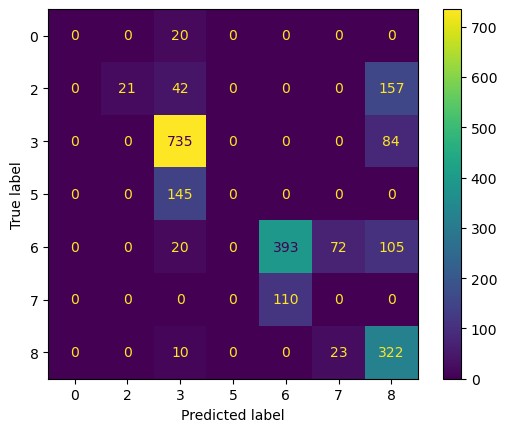

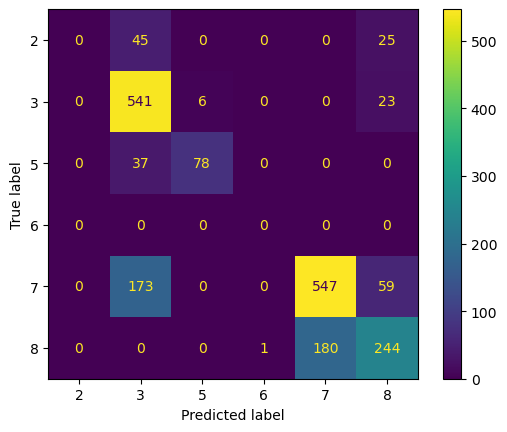

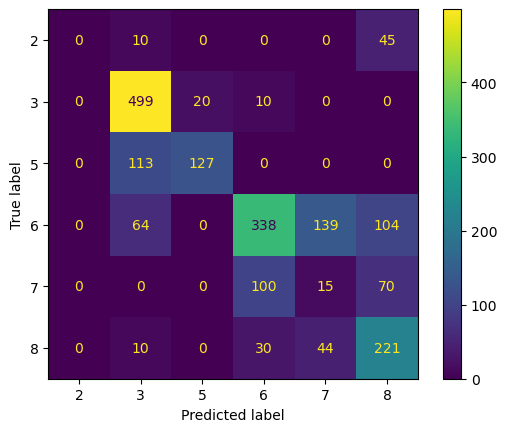

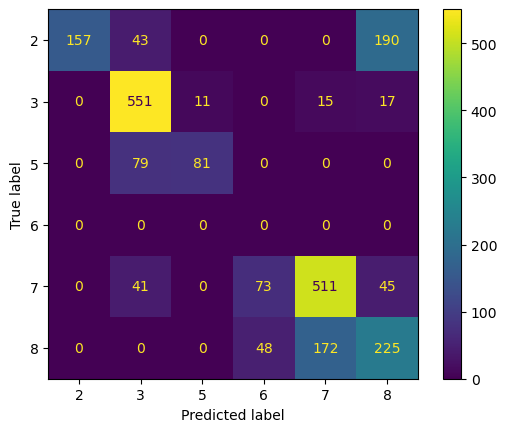

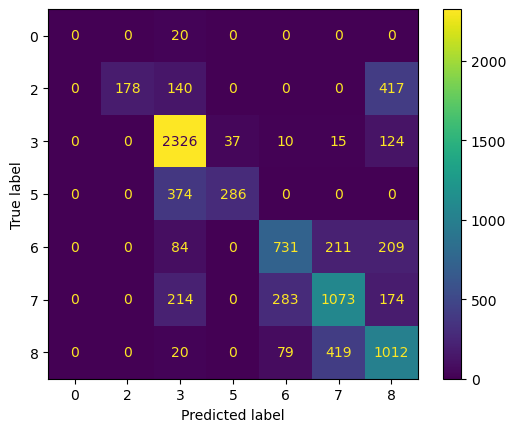

In [31]:
# The number of nonnan elements in each testing borehole
bhi_test_num_el = (np.ones(4)*len(encoded_classes) - np.isnan(encoded_classes[:, [8, 0, 4, 2]]).sum(axis=0)).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, roc_auc_score, log_loss



from collections import defaultdict
dict_metrics_bh = {i: defaultdict(list) for i in range(len(bhs))}

y_true=[]; y_pred=[]; targets = []; inputs = []#to test entire set of bhs
for loc in range(len(bhs)):   

    # dict_metrics_bh["z_bh"].append(df_test["z"][:bhi_test_num_el[loc]])
    # dict_metrics_bh["y_test_bh"].append( torch.tensor(Y_test[:bhi_test_num_el[bh_loc], :][np.where(z_bh9>=1.86)] ))
    z_bh = df_test["z"][:bhi_test_num_el[loc]]
    dict_metrics_bh[loc]["z_bh"]=(df_test["z"][:bhi_test_num_el[loc]])
    dict_metrics_bh[loc]["y_test_bh"]=( torch.tensor(Y_test[:bhi_test_num_el[loc], :][np.where(z_bh>=1.86)] ))

   # y_test_cat_bh[y_test_cat_bh==5] = 4
    dict_metrics_bh[loc]["y_test_bh_cat"]=np.array(encoded_classes[:, [8, 0, 4, 2]][np.where(z_bh>=1.86)] [:, loc], dtype=int)
   
#     #===========================================
#     #merge OL and Pt
    dict_metrics_bh[loc]["y_test_bh_cat"][dict_metrics_bh[loc]["y_test_bh_cat"]==4] = 5
#     #===========================================
    pred_probs_bh =  probabilities[loc][np.where(depth<=max(z_bh))]
    z_bh = z_bh[z_bh>=1.86]

    #dict_metrics_bh[loc]["pred_probs_bh"] = probabilities[loc][np.where(depth<=max(z_bh))]
    pred_probs_bh = torch.cat([torch.zeros(len(pred_probs_bh), 2), pred_probs_bh], -1).clone().detach().requires_grad_(True)
    pred_class = np.array(most_prob_profile[loc][np.where(depth<=max(z_bh))],dtype=int)
    dict_metrics_bh[loc]["pred_probs_bh"] = pred_probs_bh
    dict_metrics_bh[loc]["pred_class_bh"] = pred_class

    loss = torch.nn.CrossEntropyLoss()
    input = dict_metrics_bh[loc]["pred_probs_bh"]
    target = dict_metrics_bh[loc]["y_test_bh"]
    output = loss(input, target)
    output.backward()
    
    print("test_loc", loc)
    print("cross entropy", output.item())

    targets.append(target.numpy()); inputs.append(input.detach())
    print("cross entropy skl", log_loss( target.numpy(), input.detach().numpy()))
    print("cross entropy manual", cross_entropy( target.numpy(), input.detach().numpy()))
    
    print("\naccuracy score: ",  accuracy_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"]))
    
    print("\nprecision score: ",  precision_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"], average = "weighted", zero_division = 0.0 ))
    
    ConfusionMatrixDisplay.from_predictions(dict_metrics_bh[loc]["y_test_bh_cat"],
                                            dict_metrics_bh[loc]["pred_class_bh"],
                                           #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                           )
    
    print("------------------------------------")
    y_true.append(dict_metrics_bh[loc]["y_test_bh_cat"])
    y_pred.append(dict_metrics_bh[loc]["pred_class_bh"])


    
print("\naccuracy score total: ",  accuracy_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred)
                                                  ))
print("\nprecision score total: ",  precision_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred), 
                                                  average = "weighted", zero_division = 0.0 ))


print("cross entropy skl total", log_loss( np.concatenate(targets), np.concatenate(inputs)))


ConfusionMatrixDisplay.from_predictions(np.concatenate(y_true),
                                        np.concatenate(y_pred),
                                        #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                        )